In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import gc
gc.collect()
# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


0

### Importing Data by changing bits so as to fully Load the data in memory

In [2]:
import pandas as pd
train_df=pd.read_csv('../input/train.csv',iterator=True,chunksize=150_000, dtype={'acoustic_data':np.int16,'time_to_failure':np.float32})

### Checking no of rows in sample_submission.csv

In [3]:
submission=pd.read_csv('../input/sample_submission.csv')
print("No. of rows in submission :{}".format(submission.shape[0]))

No. of rows in submission :2624


### No of files in test.zip 

In [ ]:
len(os.listdir('../input/test'))

#### since we have same No. of folders in test directory as No. of rows in submission, means we have to predict time_to_failure for all of the test files

In [4]:
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.max())
    strain.append(X.min())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)


In [5]:
#train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train_df:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [6]:
X_train.columns=['ave', 'std', 'max', 'min','kurtosis','skew','1%_quantile','5%_quantile','95%_quantile',
                                '99%_quantile','abs_max','abs_mean','abs_std']

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [ ]:
y_train.head()

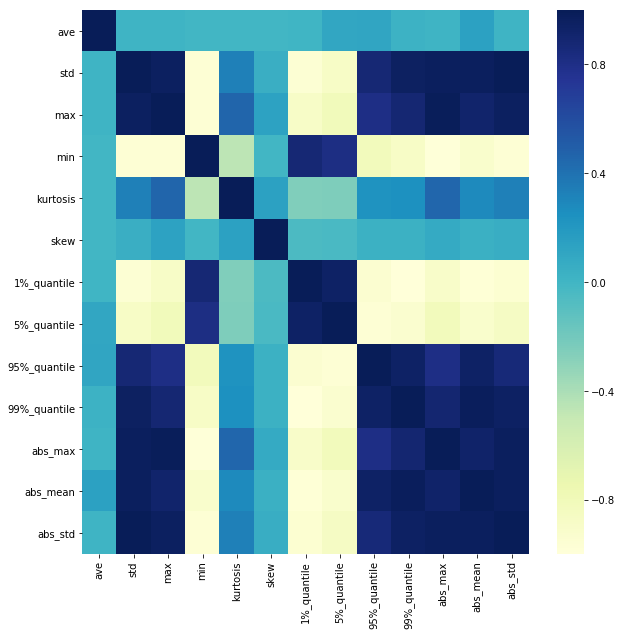

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(X_train.corr(),cmap='YlGnBu')
plt.show()

In [14]:
import xgboost as xgb 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
# Create the training and test sets
X_trai, X_tes, y_trai, y_tes = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=123)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:linear',n_estimators=150,seed=123)
#booster="gbtree" is default base learner in XGBoost

# Fit the regressor to the training set
xg_reg.fit(X_trai,y_trai)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_tes)

# Compute the rmse: rmse
mae = (mean_absolute_error(y_tes, preds))
print("MAE: %f" % (mae))

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


MAE: 2.086637


In [15]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
dmatrix = xgb.DMatrix(data=X_train_scaled, label=y_train)

reg_params = [0.05, 0.0001, 0.0005]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:linear","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
mae_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_mae = xgb.cv(dtrain=dmatrix, params=params, nfold=10, num_boost_round=100, metrics="mae", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    mae_l2.append(cv_results_mae["test-mae-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best mae as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, mae_l2)), columns=["l2","mae"]))

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Best mae as a function of l2:
       l2       mae
0  0.0500  2.202916
1  0.0001  2.200637
2  0.0005  2.199477


### Using Catboost

In [25]:
from catboost import CatBoostRegressor,Pool
train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train_scaled, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.7833090585117057}}

In [17]:
'''from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)'''

ValueError: 'mean_absolute_error' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

### Using Keras 

In [ ]:
'''import keras 
from keras.layers import Dense
from keras.model import Sequential

# Saving Number of predictors in ncols
ncols='''

In [21]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')

In [22]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [23]:
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data']#.values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    X_test.loc[seg_id, 'kurtosis'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, '1%_quantile'] = np.quantile(x,0.01)
    X_test.loc[seg_id, '5%_quantile'] = np.quantile(x,0.05)
    X_test.loc[seg_id, '95%_quantile'] = np.quantile(x,0.95)
    X_test.loc[seg_id, '99%_quantile'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()

In [ ]:
X_test.head()

In [26]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = m.predict(X_test_scaled)
submission.to_csv('submission.csv')

In [27]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,4.542910
seg_0012b5,4.974466
seg_00184e,4.420321
seg_003339,7.685218
seg_0042cc,6.596831
